# Histopathology Image Classification Using Convolutional Neural Network (CNN)
For Foundation of Deep Learning - Individual Assignment

The objective is to classify the histopathlogy patches into tumourous and non-tumourous tissues through a CNN model.

Histopathology patch dataset (PatchCamelyon Dataset): PCAM dataset: https://github.com/basveeling/pcam

A total of 32768 patches (validation set) used for storage and training efficiency

## Install Packages

In [ ]:
import h5py
import random
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets.utils import download_file_from_google_drive, _decompress

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU")
else:
    device = torch.device("cpu")
    print("GPU not available, using CPU")

Using GPU


## Download Histopathology Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMAGES_PATH = "/content/drive/MyDrive/DL_files/camelyonpatch_level_2_split_valid_x.h5"
LABELS_PATH = "/content/drive/MyDrive/DL_files/camelyonpatch_level_2_split_valid_y.h5"

In [ ]:
IMAGES_PATH = "/Users/sebastianlee/Downloads/DL_files/camelyonpatch_level_2_split_valid_x.h5"
LABELS_PATH = "/Users/sebastianlee/Downloads/DL_files/camelyonpatch_level_2_split_valid_y.h5"

In [ ]:
images = np.array(h5py.File(IMAGES_PATH)['x'])
labels = np.array([y.item() for y in h5py.File(LABELS_PATH)['y']])

## Training \& Validation Data Split

In [ ]:
random.seed(0)

In [ ]:
from sklearn.model_selection import train_test_split

def get_split_indices(dataset_length, train_ratio=0.7):
    """
    Function which splits the data into training and validation sets.
    arguments:
        dataset_length [int]: number of elements in the dataset
        train_ratio [float]: ratio of the dataset in the training set
    returns:
        train_indices [list]: list of indices in the training set (of size dataset_length*train_ratio)
        val_indices [list]: list of indices in the validation set (of size dataset_length*(1-train_ratio))
    """

    indices = np.arange(dataset_length)

    train_indices, val_indices = train_test_split(indices, train_size=train_ratio, shuffle=True)

    return train_indices, val_indices

In [ ]:
train_indices, val_indices = get_split_indices(len(labels))

## Define Dataset Class

In [ ]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

class PCAMDataset(Dataset):
    def __init__(self, data, labels, train):
        """
        Dataset class for the PCAM dataset.
        arguments:
            data [numpy.array]: all RGB 96-96 images
            labels [numpy.array]: corresponding labels
            train [bool]: whether the dataset is training or validation
        """
        super(PCAMDataset, self).__init__()
        self.data = data
        self.labels = labels
        self.train = train

        if self.train:

            self.augmentation = transforms.Compose([
                transforms.ToTensor(),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.RandomRotation(90),
            ])



    def __len__(self):

        '''
        Returns the length of the dataset
        '''
        return len(self.data)


    def __getitem__(self, idx):

        '''
        Returns image and target of the dataset
        '''

        image = (self.data[idx])
        label = int(self.labels[idx])

        if self.train:
            image = self.augmentation(image)
            # image = transforms.ToTensor()(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label



    def display_sample(self, label=0):
        '''
        Returns a random image of declared label value from the dataset
        Input:
            label: 0 indicates negative and 1 indicates positive
        '''

        indices = np.where(self.labels == label)[0]
        index = np.random.choice(indices, replace=False)

        image, target = self[index]
        plt.imshow(np.asarray(image))
        plt.show()
        print(f"Label: {target}")
        print(f"Index: {index}")

    def display_random_sample(self):
        '''
        Returns a random image of undeclared label value from the dataset
        '''
        index = np.random.choice(len(self.labels), replace=False)
        print(f"Index: {index}")

        image, target = self[index]
        plt.imshow(np.asarray(image))
        plt.show()


    def get_label(self, index):
        '''
        Returns the indexed label from the training dataset
        '''
        return self.labels[index]

    def get_image(self, index):
        '''
        Returns the indexed label from the training dataset
        '''
        return self.data[index]

    def plot_distribution(self, dataset_type='training'):
        """
        Plot the distribution of labels in the training or validation dataset.
        Inputs:
            dataset_type: 'training' or 'validation'
        """
        unique_labels, counts = np.unique(self.labels, return_counts=True)

        plt.bar(unique_labels, counts, align='center', alpha=0.7)
        plt.xticks(unique_labels)
        plt.xlabel('Label')
        plt.ylabel('Total Count')
        plt.title(f'Distribution of Labels in {dataset_type} Dataset')
        plt.show()



In [ ]:
BATCH_SIZE = 32

In [ ]:
train_dataset = PCAMDataset(images[train_indices], labels[train_indices], train=True)
val_dataset = PCAMDataset(images[val_indices], labels[val_indices], train=False)
# train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

## Tumour \& Non-Tumour Sample Comparison

### Negative Random Sample

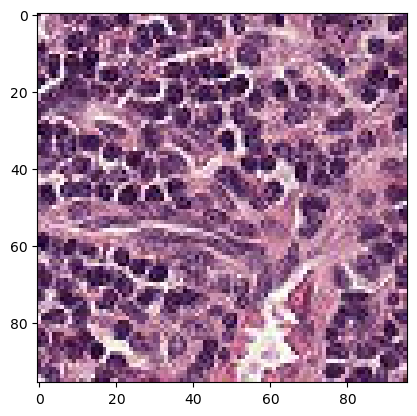

Label: 0
Index: 16934


In [ ]:
train_dataset.display_sample(0)

### Positive Random Sample

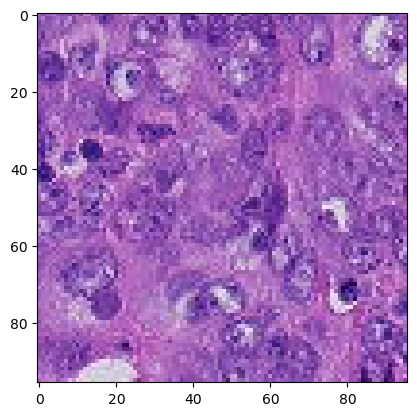

Label: 1
Index: 624


In [ ]:
train_dataset.display_sample(1)

### Observation

Based on just the observation, there are a couple of features that stands out to distinguish the difference between tumourous and non-tumours patches.

First feature is the shape of the nuclei. Generally, normal tissues appear to have regular and round shapes. Tumour tissues appear to have irregularly-displaced with oval to stretched-looking, irregular shapes.

Second feature is the structure of microfilaments. Normal tissues appear to have absorbed less dyes than tumour tissues, and have structured forms. Most of the tumour images visualized appears very pink compared to the normal images and unstructured.

Index: 1698


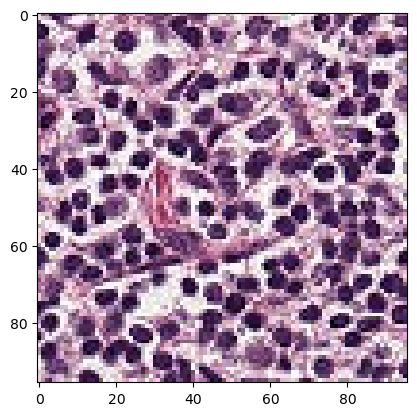

In [ ]:
# Extra
train_dataset.display_random_sample()

Index: 1698
Based on the previous observation, the patch contains a lack of stain on microfilament, structured tissue, and regularly shaped nuclei. This is assumed to be a non-tumourous patch.

In [ ]:
train_dataset.get_label(1698)

0

## Distribution of Tumourous and Non-Tumourous Labels


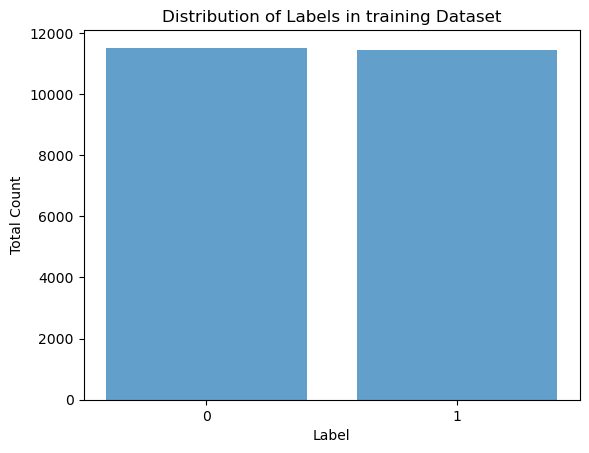

In [ ]:
train_dataset.plot_distribution(dataset_type='training')

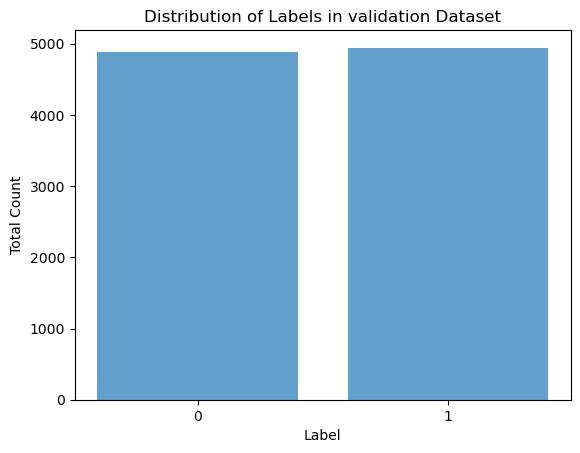

In [ ]:
val_dataset.plot_distribution(dataset_type='validation')

## Model Architecture and Justification

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout()
        self.sig = nn.Sigmoid()

    def forward(self, x):

        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)

        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        x = x.view(-1, 64 * 12 * 12)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sig(x)


        return x


The following model Architecture consist of 3 convolutional layers, activation layers and pooling layers, finishing off with 2 fully connected layer, dropout layer and sigmoid activation.

2D CNN is chosen for convolutional layers as it is generally used in image analysis and is designed to extract features from images. Additionally, CNN is memory and computationally-efficient. Each convolutional layer uses a 3x3 kernel to convolve the input.

For activation layers, although Leaky ReLU is more stable and does better job in mitigating dead neuron problems when compared to traditional ReLU, it is more computationally expensive. To save computation time, ReLU is chosen instead.

MaxPooling2D is used as pooling layers to max pooling with a 2x2 kernel and a stride of 2. It is designed to remove insignificant features while retaining important features.

Fully connected layers allow extraction of complex and high-level features from convolutional and pooling layers, and produce final binary classification output. Therefore, two fully connected layers are utilized in the model. The first layer processes the 9216 features from the third convolutional and pooling layers, and reduces it to 128 neurons. The second layer processes the output from the first layer and produces the final 2 output features.

A dropout layer is added between the first fully connected layer and the second fully connected layer to prevent overfitting during training. The layer randomly deactivates a fraction of neurons during training, preventing the model from relying heavily on specific features, thereby enhancing generalization. The standard value of 0.5 is chosen as it is the convention and computationall efficient.

Finally, The sigmoid activation function, located after the second fully connected layer, is applied at the end of the model, which produces the final probablistic output values between 0 and 1. The model's output is interpreted as the likelihood of belonging to one of the two classes.


In [ ]:
model = ConvNet().to(device)

## Hyperparameter Initialization and Model Training

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 9.3 MB/s eta 0:00:00


In [ ]:
from torchmetrics.classification import Accuracy
import torch.optim as optim

lr = 0.01
num_epochs = 50
BATCH_SIZE = 32
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()
metric = Accuracy(task="binary").to(device)


In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

print(f"  Learning Rate: {lr:.4f}, Batch Size: {BATCH_SIZE}, Number of layers: {3}")

for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_metric = 0.0

    for image, target in train_dataloader:
        image, target = image.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output[:,1], target.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_metric += metric(output[:,1], target.float())

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_metric = train_metric / len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_metric = 0.0

    with torch.no_grad():
        for image, target in val_dataloader:
            image, target = image.to(device), target.to(device)
            output = model(image)
            loss = criterion(output[:,1], target.float())

            val_loss += loss.item()
            val_metric += metric(output[:,1], target.float())

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_metric = val_metric / len(val_dataloader)

    train_accuracies.append(avg_train_metric)
    val_accuracies.append(avg_val_metric)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Print results
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_metric:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_metric:.4f}")


  Learning Rate: 0.0100, Batch Size: 32, Number of layers: 3
Epoch 1/50:
  Train Loss: 0.7011, Train Accuracy: 0.5022
  Val Loss: 0.6926, Val Accuracy: 0.4969
Epoch 2/50:
  Train Loss: 0.6931, Train Accuracy: 0.5022
  Val Loss: 0.6926, Val Accuracy: 0.4969
Epoch 3/50:
  Train Loss: 0.6927, Train Accuracy: 0.5022
  Val Loss: 0.6924, Val Accuracy: 0.4969
Epoch 4/50:
  Train Loss: 0.6929, Train Accuracy: 0.5022
  Val Loss: 0.6924, Val Accuracy: 0.4969
Epoch 5/50:
  Train Loss: 0.6926, Train Accuracy: 0.5022
  Val Loss: 0.6922, Val Accuracy: 0.4969
Epoch 6/50:
  Train Loss: 0.6927, Train Accuracy: 0.5022
  Val Loss: 0.6921, Val Accuracy: 0.4969
Epoch 7/50:
  Train Loss: 0.6924, Train Accuracy: 0.5022
  Val Loss: 0.6918, Val Accuracy: 0.4969
Epoch 8/50:
  Train Loss: 0.6924, Train Accuracy: 0.5022
  Val Loss: 0.6916, Val Accuracy: 0.4969
Epoch 9/50:
  Train Loss: 0.6918, Train Accuracy: 0.5021
  Val Loss: 0.6911, Val Accuracy: 0.4969
Epoch 10/50:
  Train Loss: 0.6915, Train Accuracy: 0.5022

## Model Validation

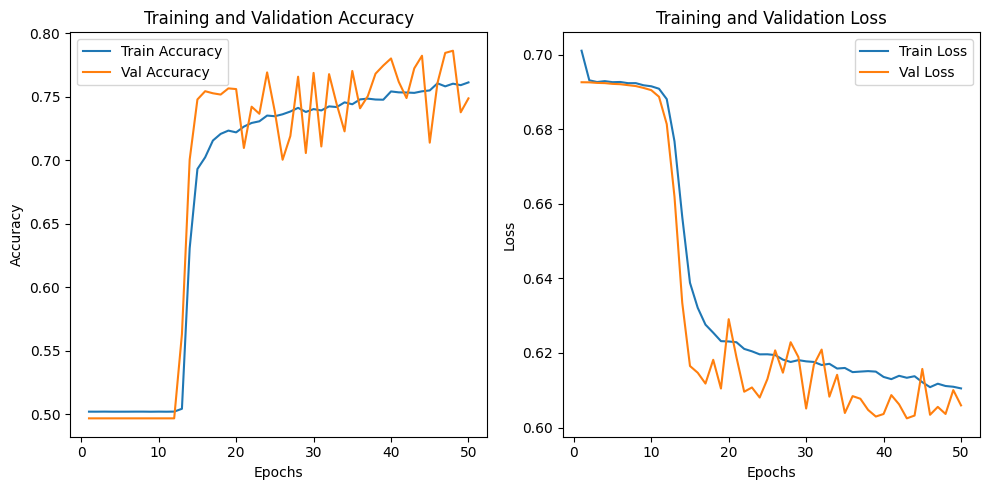

In [ ]:
# Plotting
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))

# Convert tensors to lists
train_accuracies_list = [acc.item() for acc in train_accuracies]
val_accuracies_list = [acc.item() for acc in val_accuracies]

# Plotting Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies_list, label='Train Accuracy')
plt.plot(epochs, val_accuracies_list, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting Training Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

I chose Accuracy from Torchmetrics as the metric because it provides a straightforward measure of the overall correctness of the model predictions, which is crucial for a binary classification task, including tumour tissue classification.

Training accuracy and validation accuracy originally started at 0.5022 and 0.4969, respectively. No improvements in the model can be seen until Epoch 14. Between Epoch 13 and Epoch 15, the model significantly improved. After Epoch 15, The model gradually improved over time until epoch 50, where it eventually acheived training accuracy and validation accuracy of 0.7612 and 0.7487.

Initial stagnant accuracies and losses suggest that the model struggled to learn, suggesting the use of different hyperparameters and initialization. A significant increase in accuracies and decrease in losses between Epoch 13 and 15 suggest that the model may have found key features that determined the classification, and learned and generalized well to the data. Although the gap between the training accuracy and validation accuracy appeared to have narrowed at the end and both losses also significantly decreased, the validation accuracy struggled to maintain stability within testing accuracy, indicates that the learning rate of the last 30 epochs may have been too big.


## Hyperparameter Optimization (Learning Rate, Batch Size, Number of Layers)

In [ ]:
!pip install scikit-optimize
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 3.1 MB/s eta 0:00:00


In [ ]:
from skopt import gp_minimize
from skopt.utils import use_named_args

In [ ]:
from torchmetrics.classification import Accuracy
import torch.optim as optim

from skopt.space import Real, Integer, Categorical

dimensions = [
    Categorical(name='learning_rate', categories=[0.1, 0.01, 0.001]),
    Categorical(name='batch_size', categories=[16, 32, 64]),
    Categorical(name='num_layers', categories=[2, 3, 4])
]

parameters_default_values = [0.01, 16, 3]
num_epochs = 20
criterion = nn.BCEWithLogitsLoss()
metric = Accuracy(task="binary").to(device)

In [ ]:
# ConvNet Adjusted for hyperparameter optimization

class ConvNetAdjusted(nn.Module):
    def __init__(self, num_layers=3):
        super(ConvNetAdjusted, self).__init__()

        layers = []

        # Add first layer
        layers.append(nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))

        # Add subsequent layers
        for i in range(1, num_layers):
            in_channels = 16 * 2**(i-1)
            out_channels = 16 * 2**i

            # Add convolutional layer
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))

        # Calculate the input size for the fully connected layer based on the number of layers
        fc_input_size = out_channels * (96 // (2**num_layers))**2

        # Add fully connected layers and other components
        self.convolutions = nn.Sequential(*layers)
        self.fc1 = nn.Linear(fc_input_size, 128)
        self.fc2 = nn.Linear(128, 2)
        self.dropout = nn.Dropout()
        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.convolutions(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sig(x)

        return x

In [ ]:
# Create a function that take as input your set of hyperparameters and return a score to be minimized (choose wisely your scoring function)

@use_named_args(dimensions=dimensions)
def fit_opt(learning_rate, batch_size, num_layers):

    learning_rate = int(learning_rate)
    batch_size = int(batch_size)
    num_layers = int(num_layers)

    model = ConvNetAdjusted(num_layers=num_layers).to(device)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)



    for epoch in range(num_epochs):
        # Training
        model.train()
        for image, target in train_dataloader:
            image, target = image.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output[:, 1], target.float())
            loss.backward()
            optimizer.step()

        # Validation
        model.eval()
        val_metric = 0.0

        with torch.no_grad():
            for image, target in val_dataloader:
                image, target = image.to(device), target.to(device)
                output = model(image)
                val_metric += metric(output[:, 1], target.float()).item()

    score = val_metric / len(val_dataloader)

    return -score

In [ ]:
gp_result = gp_minimize(

    func=fit_opt,
    dimensions=dimensions,
    n_calls=15,
    x0=parameters_default_values,
    callback=[lambda res: print(f"Iteration {len(res.x_iters)}, Best Score: {np.min(res.func_vals):.4f}")]

    )

print(f"Optimal set of parameters found at iteration {np.argmin(gp_result.func_vals)}")
print(gp_result.x)

Iteration 1, Best Score: -0.5059
Iteration 2, Best Score: -0.5059
Iteration 3, Best Score: -0.5059
Iteration 4, Best Score: -0.5059
Iteration 5, Best Score: -0.5059
Iteration 6, Best Score: -0.5102
Iteration 7, Best Score: -0.5102
Iteration 8, Best Score: -0.5102
Iteration 9, Best Score: -0.5102
Iteration 10, Best Score: -0.5102
Iteration 11, Best Score: -0.5102
Iteration 12, Best Score: -0.5102
Iteration 13, Best Score: -0.5102


/usr/local/lib/python3.10/dist-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration 14, Best Score: -0.5102
Iteration 15, Best Score: -0.5102
Optimal set of parameters found at iteration 5
[0.01, 32, 2]


In [ ]:
# Calculated optimal set of parameters:

lr = 0.01 # BEST ONE 0.01 did 0.001 - too slow 0.1 - too quick
batch_size = 32 # BEST ONE 16 did 32 - okay, 128 - no good
num_layers = 2 # BEST ONE 3 did 4 - too slow
num_epochs = 50

In [ ]:
train_accuracies = []
val_accuracies = []
train_losses = []
val_losses = []

model = ConvNetAdjusted(num_layers=num_layers).to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)
criterion = nn.BCEWithLogitsLoss()
metric = Accuracy(task="binary").to(device)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

print(f"  Learning Rate: {lr:.4f}, Batch Size: {batch_size}, Number of layers: {num_layers}")

# Training loop
for epoch in range(num_epochs):
    # Training
    model.train()
    train_loss = 0.0
    train_metric = 0.0

    for image, target in train_dataloader:
        image, target = image.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(image)
        loss = criterion(output[:,1], target.float())
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_metric += metric(output[:,1], target.float())

    avg_train_loss = train_loss / len(train_dataloader)
    avg_train_metric = train_metric / len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    val_metric = 0.0

    with torch.no_grad():
        for image, target in val_dataloader:
            image, target = image.to(device), target.to(device)
            output = model(image)
            loss = criterion(output[:,1], target.float())

            val_loss += loss.item()
            val_metric += metric(output[:,1], target.float())

    avg_val_loss = val_loss / len(val_dataloader)
    avg_val_metric = val_metric / len(val_dataloader)

    train_accuracies.append(avg_train_metric)
    val_accuracies.append(avg_val_metric)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    # Print results
    print(f"Epoch {epoch + 1}/{num_epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_metric:.4f}")
    print(f"  Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_metric:.4f}")


  Learning Rate: 0.0100, Batch Size: 32, Number of layers: 2
Epoch 1/50:
  Train Loss: 0.6932, Train Accuracy: 0.4981
  Val Loss: 0.6921, Val Accuracy: 0.5058
Epoch 2/50:
  Train Loss: 0.6910, Train Accuracy: 0.4982
  Val Loss: 0.6906, Val Accuracy: 0.5058
Epoch 3/50:
  Train Loss: 0.6863, Train Accuracy: 0.5007
  Val Loss: 0.6817, Val Accuracy: 0.5038
Epoch 4/50:
  Train Loss: 0.6701, Train Accuracy: 0.6006
  Val Loss: 0.6642, Val Accuracy: 0.6037
Epoch 5/50:
  Train Loss: 0.6492, Train Accuracy: 0.6613
  Val Loss: 0.6585, Val Accuracy: 0.5831
Epoch 6/50:
  Train Loss: 0.6336, Train Accuracy: 0.7013
  Val Loss: 0.6254, Val Accuracy: 0.7308
Epoch 7/50:
  Train Loss: 0.6277, Train Accuracy: 0.7135
  Val Loss: 0.6254, Val Accuracy: 0.7113
Epoch 8/50:
  Train Loss: 0.6247, Train Accuracy: 0.7159
  Val Loss: 0.6237, Val Accuracy: 0.7132
Epoch 9/50:
  Train Loss: 0.6225, Train Accuracy: 0.7224
  Val Loss: 0.6210, Val Accuracy: 0.7370
Epoch 10/50:
  Train Loss: 0.6221, Train Accuracy: 0.7244

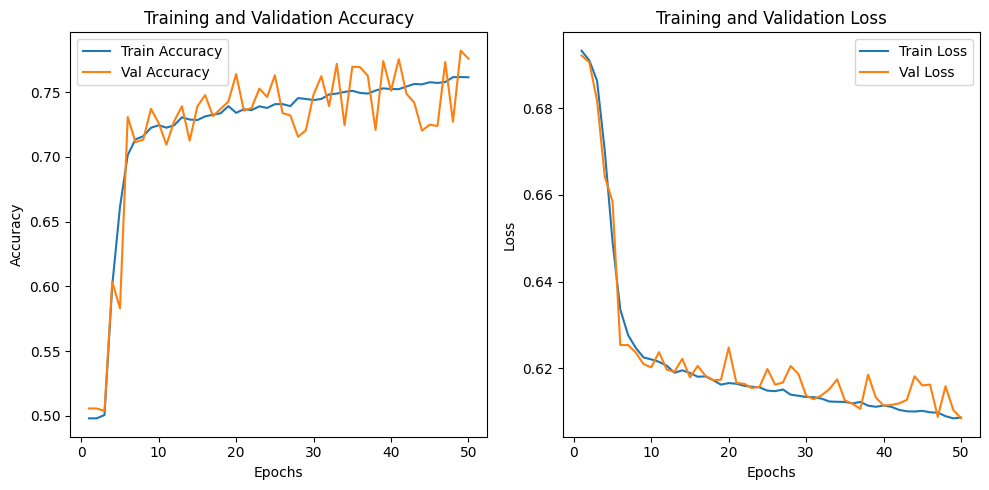

In [ ]:
# Plotting
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(10, 5))

# Convert tensors to lists
train_accuracies_list = [acc.item() for acc in train_accuracies]
val_accuracies_list = [acc.item() for acc in val_accuracies]

# Plotting Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracies_list, label='Train Accuracy')
plt.plot(epochs, val_accuracies_list, label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plotting Training Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()

Although the hyperparameter optimization successfully addressed the initial challenge of stagnant accuracies and losses observed in the first model, the overall performance of the model remained relatively consistent compared to the first model. It may be possible to further improve the model through more extended training duration, such as increasing the number of epochs to 100 and have a dynamic learning rate. Extending the training epoch allows the model to explore more complex patterns and refine its parameters, resulting in additional performance gains. Additionally, it could push the model's accuracy beyond 0.8 and achieve even lower losses while minimizing the overfit of the model. However, due to time contraints and limited GPU resources, this approach was not performed.

## Model Reasoning

### Grad-CAM

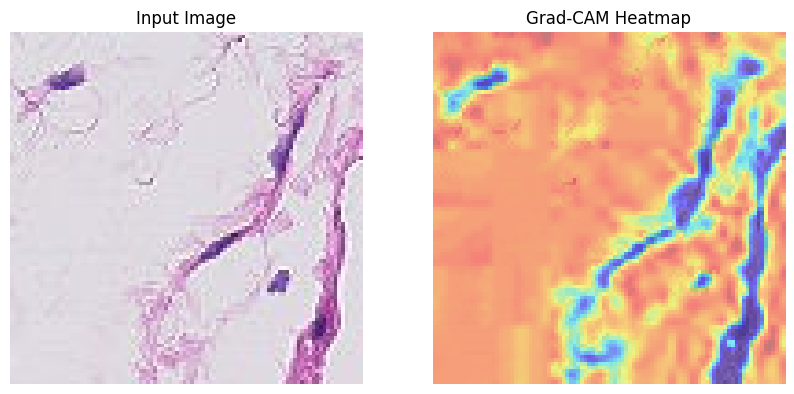

In [ ]:
import torch.nn.functional as F

# Function to generate Grad-CAM heatmap
def generate_grad_cam(model, input_tensor, class_index):
    model.eval()

    # Set the requires_grad attribute of the input tensor to True for gradients
    input_tensor.requires_grad_(True)

    # Forward pass to get the model prediction
    output = model(input_tensor)

    # Get the output score for the target class
    score = output[0, class_index]

    # Backward pass to get the gradients of the score w.r.t the input
    score.backward()

    # Get the gradients from the input tensor
    gradients = input_tensor.grad

    # Global average pooling of the gradients
    weights = F.adaptive_avg_pool2d(gradients, (1, 1))

    # Replace 'model.feature_activations' with the appropriate layer or attribute in your model
    # For example, if you want to use the last convolutional layer, you can use 'model.convolutions[-3]'.
    # Adjust this based on your model architecture.
    conv_layer = model.convolutions[5]

    # Weighted sum of the feature maps (activations)
    cam = torch.sum(weights * conv_layer(input_tensor), dim=1, keepdim=True)

    # Apply ReLU to obtain only positive contributions
    cam = F.relu(cam)

    # Upsample the CAM to the size of the input image
    cam = F.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)

    # Normalize the CAM for visualization (optional)
    cam = cam / cam.max()

    normalized_cam = (cam - cam.min()) / (cam.max() - cam.min())

    return normalized_cam.squeeze().detach().cpu().numpy()


# Choose a particular image and corresponding label for Grad-CAM visualization
image = train_dataset.get_image(5555)
label = train_dataset.get_label(5555)

# Preprocess the input image
preprocess = transforms.Compose([
    transforms.ToTensor(),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
    # transforms.RandomRotation(90),
])
input_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension

# Forward pass to get the model prediction
output = model(input_tensor)

# Choose the class index for which you want to visualize the Grad-CAM
class_index = torch.argmax(output)

# Generate Grad-CAM heatmap
grad_cam = generate_grad_cam(model, input_tensor, class_index)

# Plot the input image and its corresponding Grad-CAM heatmap side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the input image
axes[0].imshow(image, cmap='gray')  # Specify colormap for the input image
axes[0].set_title('Input Image')
axes[0].axis('off')

# Plot the Grad-CAM heatmap
axes[1].imshow(grad_cam, cmap='jet', alpha=0.7)  # Overlay Grad-CAM on the input image
axes[1].imshow(image, alpha=0.3)  # Overlay input image for comparison
axes[1].set_title('Grad-CAM Heatmap')
axes[1].axis('off')

plt.show(block=False)


Grad-CAM was used to highlight the regions that contribute the most to the activation in an image. It initially utilizes forward pass to obtain prediction. Then, backward pass is used to calculate gradient between the predicted score and the last convolutional layer, and the resulting gradients are used to calculate weighted sum. Lastly, through activation layer, the positive contribution is captured. In this case, the dark region represents higher contribution to the prediction. By visualizing the Grad-CAM heatmap, one can interpret which regions of the image were crucial in the model's decision-making for a specific class. The technique can also can provide a reasoning why the model correctly classified an image, the model incorrectly classified an image. However, the heatmap does not represent the model's overall decision-making process.

### Saliency Maps

(-0.5, 95.5, 95.5, -0.5)

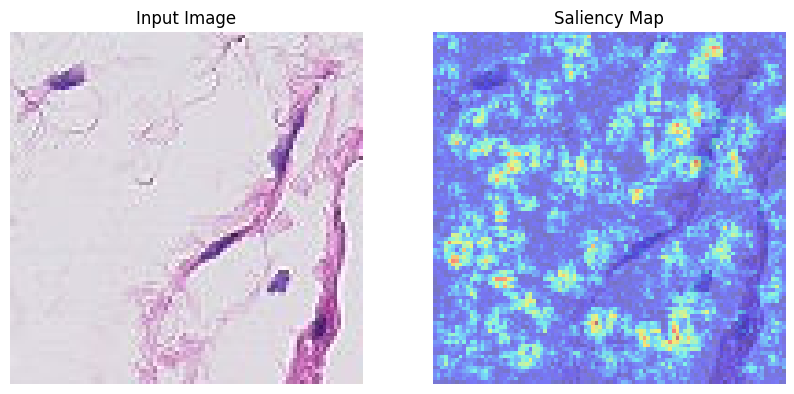

In [ ]:
image = train_dataset.get_image(5555)
label = train_dataset.get_label(5555)

preprocess = transforms.Compose([
                transforms.ToTensor(),
                # transforms.RandomHorizontalFlip(),
                # transforms.RandomVerticalFlip(),
                # transforms.RandomRotation(90),
              ])

input_tensor = preprocess(image).unsqueeze(0).to(device)  # Add batch dimension

# Set the model to evaluation mode
model.eval()

# Set the requires_grad attribute of the input tensor to True for gradients
input_tensor.requires_grad_(True)

# Forward pass to get the model prediction
output = model(input_tensor)

# Choose the class index for which you want to visualize the saliency map
class_index = torch.argmax(output)

model.zero_grad()

# Backward pass to get the gradients of the output w.r.t the input
output[0, class_index].backward()

# Get the gradients from the input tensor
saliency_map = input_tensor.grad.squeeze(0).abs().cpu().numpy()

# Normalize the saliency map for visualization
saliency_map = saliency_map / saliency_map.max()

normalized_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())

# Convert the saliency map back to a uint8 image format (0-255)
saliency_map_image = np.uint8(255 * normalized_saliency_map)

# Aggregate across the channels
aggregate_saliency = saliency_map.sum(axis=0)

# Plot the input image and its corresponding saliency map side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Plot the input image
axes[0].imshow(image)
axes[0].set_title('Input Image')
axes[0].axis('off')

# Plot the saliency map
axes[1].imshow(aggregate_saliency, cmap='jet', alpha=0.7)  # Overlay saliency map on the input image
axes[1].imshow(image, alpha=0.3)  # Overlay input image for comparison
axes[1].set_title('Saliency Map')
axes[1].axis('off')

The saliency map does not appear to assist in interpreting the decision making process of the model. The heated areas, (or inverted cooled areas), are not highlighting the same areas as the areas that were highlighted through the Grad-CAM technique.

Although it may be true that the saliency maps are useful for decision interpretation of CNNs, they have some limitations, in which one of them may be already shown in the resulting graph. The limitations include: exploding or vanishing gradients, low resolution, and model architecture dependency.

The first limitation of vanishing or exploding gradients results in unclear maps as it occurs during backpropagation process. It is very likely that the vanishing gradient may have resulted in lack of interpretability in graph. Second, the maps may not capture high-resolution details as the resolution is often lower than the input images. Finally, the maps are highly dependent on specific architectures of CNNs and layers can affect the gradient computation and thereby interpretability.